# Proportional Fairness Scheduler

In this notebook we illustrate how to schedule users in an OFDM time/frequency
resource grid according to a proportional fairness criterion.  
We consider a single-user MIMO system, i.e., at most one user can be scheduled
in a resource element.

We provide a simplistic but pedagogical example where the rate achievable by
users across the OFDM resource grid follows an autoregressive process.  
This example can be used as boilerplate code for use in a more realistic setting.

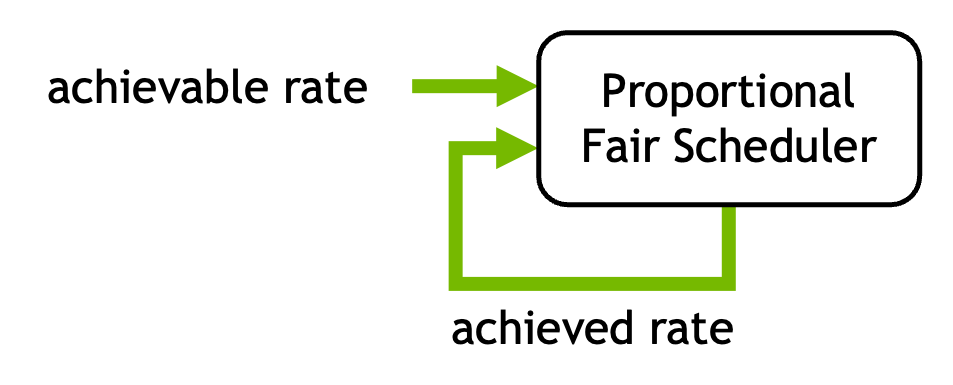

## Imports

We start by importing Sionna and the relevant external libraries:

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna.sys
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [ ]:
# Additional external libraries
import matplotlib.pyplot as plt
import numpy as np

# Sionna components
from sionna.phy import config, Block
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.sys import PFSchedulerSUMIMO

# Set random seed for reproducibility
sionna.phy.config.seed = 48

# Internal computational precision
sionna.phy.config.precision = 'single'  # 'single' or 'double'

## The main principle

The [proportional fairness (PF) scheduler](https://nvlabs.github.io/sionna/sys/api/scheduling.html) distributes the available
resources across users by maximizing the sum of logarithms of the
long-term throughputs $T(u)$ across the users $u=1,2,\dots$:  
$$
\max \sum_u \log T(u).
$$

To this aim, the scheduler assigns each resource $i$ to the user with the highest PF
metric, defined as the ratio of the *achievable* rate on resource $i$ to
the throughout achieved by the user in the past [[1]](#references),
[[2]](#references), [[3]](#references).

As a result, resources are distributed (roughly) uniformly across users, who are
scheduled when their channel conditions reach a local peak. 

## Basic scenario

To illustrate the key principles of proportional fairness, we design a simple
example where each user's achievable rate on each subcarrier evolves according
to an autoregressive (AR) process centered around a user-specific mean. 

We first set the main simulation parameters:

In [2]:
# Number users
num_ut = 3

# OFDM resource grid
num_subcarriers = 12
num_ofdm_symbols = 2
num_slots = 200

# User-specific average achievable rate
se_achievable_avg = config.tf_rng.uniform([num_ut], minval=1, maxval=7)

# User-specific AR multiplicative parameter
rho = config.tf_rng.uniform([num_ut], minval=0.8, maxval=.95)

### Generate achievable rate time series

We now generate the achievable rate time series for each user, on all
subcarriers.  
Note that this section would be typicall replaced by generating channel
realizations according to user mobility and computing the related SINR, as
shown, e.g.,
in the [link adaptation
notebook](https://nvlabs.github.io/sionna/sys/tutorials/LinkAdaptation.html).

In [3]:
class AR1(Block):
    """ Autoregressive process of order 1 for the achievable rate evolution """
    def __init__(self, mean, rho, precision=None):
        super().__init__(precision=precision)
        self.mean = tf.cast(mean, self.rdtype)
        self.rho = tf.cast(rho, self.rdtype)
        self.val = tf.Variable(mean, dtype=self.rdtype)

    def call(self):
        val_new = self.val * self.rho + self.mean * (1 - self.rho) + \
            config.tf_rng.normal(self.val.shape, dtype=self.rdtype, stddev=1)
        val_new = tf.maximum(tf.cast(0, self.rdtype), val_new)
        self.val.assign(val_new)
        return self.val

In [4]:
# Broadcast across resources
se_achievable_avg = tf.tile(se_achievable_avg[tf.newaxis, :],
                            [num_subcarriers, 1])
rho = tf.tile(rho[tf.newaxis, :],
              [num_subcarriers, 1])

# Create the AR(1) process
se_achievable_ar = AR1(se_achievable_avg, rho)

# Generate the achievable rate time series
se_achievable_hist = np.zeros([num_slots*num_ofdm_symbols,
                               num_subcarriers,
                               num_ut])
for slot in range(num_slots*num_ofdm_symbols):
    se_achievable_hist[slot, :] = se_achievable_ar().numpy()


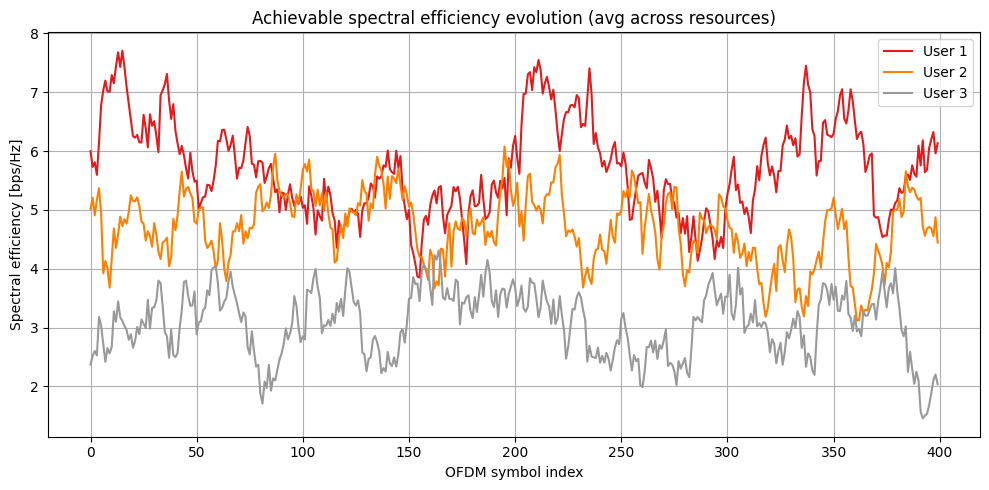

In [5]:
# Create a color map or list of colors
colors = plt.cm.Set1(np.linspace(0, 1, num_ut))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('OFDM symbol index')
ax.set_ylabel('Spectral efficiency [bps/Hz]')
ax.set_title('Achievable spectral efficiency evolution (avg across resources)')
for ut in range(num_ut):
    # Average SE across subcarriers
    ax.plot(se_achievable_hist[..., ut].mean(axis=(-1)), color=colors[ut], label=f'User {ut+1}')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

## Schedule users

We first instantiate a [PFSchedulerSUMIMO](https://nvlabs.github.io/sionna/sys/api/scheduling.html#sionna.sys.PFSchedulerSUMIMO) object to schedule users in a single-user
MIMO system.

In [6]:
# Instantiate the scheduler
scheduler = PFSchedulerSUMIMO(
    num_ut,
    num_subcarriers,
    num_ofdm_symbols,
    beta=.95)

# Use XLA compilation to speed up simulations
@tf.function(jit_compile=True)
def scheduler_xla(rate_last_slot, rate_achievable_curr):
    return scheduler(rate_last_slot, rate_achievable_curr)

The scheduler will now assign the OFDM resources to the different users
according to the proportional fairness principle.

In [7]:
# Initialize the achieved rate and scheduling decisions history
se_achieved_hist = np.zeros([num_slots, num_ut])
ut_scheduled_hist = np.zeros([num_slots, num_ofdm_symbols, num_subcarriers])

# Initialize the rate achieved in the last slot to 0
se_last_slot = tf.zeros([num_ut], dtype=tf.float32)

for slot in range(num_slots):
    # Extract the achievable rate in the current slot
    se_achievable_curr = se_achievable_hist[slot*num_ofdm_symbols:(slot+1)*num_ofdm_symbols, :]

    # Schedule users in the current slot across the resource grid
    # [num_ofdm_sym, num_subcarriers, num_ut, num_streams_per_ut]
    is_scheduled = scheduler(se_last_slot,
                             se_achievable_curr)

    # Sum spectral efficiency over scheduled resources in the current slot
    is_scheduled_re = tf.reduce_all(is_scheduled, axis=-1)
    se_last_slot = tf.cast(
        is_scheduled_re, se_achievable_curr.dtype) * se_achievable_curr
    # [num_ut]
    se_last_slot = tf.reduce_sum(se_last_slot, axis=[-2, -3])

    # User scheduled in each resource element
    # [num_ofdm_sym, num_subcarriers]
    ut_scheduled = tf.argmax(tf.reduce_sum(
        tf.cast(is_scheduled, tf.int32), axis=-1), axis=-1)

    # Store the results
    se_achieved_hist[slot, :] = se_last_slot.numpy()
    ut_scheduled_hist[slot, :] = ut_scheduled.numpy()

# Reshape the scheduling history
ut_scheduled_hist = np.reshape(ut_scheduled_hist,
                               [num_slots*num_ofdm_symbols, num_subcarriers])

# Per-user achieved rate
rate_achieved_pf = se_achieved_hist.sum(axis=0)
# PF metric
pf_metric_pf = np.sum(np.log(rate_achieved_pf))

We can now visualize for a specific resource element in the grid, when a user is scheduled:

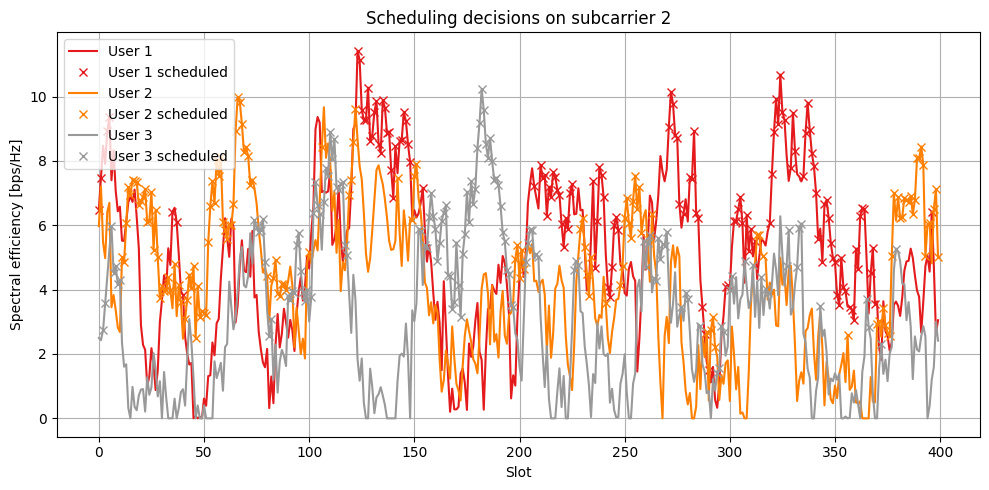

In [8]:
# Select subcarrier to plot
sc = 2

# Create a color map or list of colors
colors = plt.cm.Set1(np.linspace(0, 1, num_ut))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Slot')
ax.set_ylabel('Spectral efficiency [bps/Hz]')
ax.set_title(f'Scheduling decisions on subcarrier {sc}')
for ut in range(num_ut):
    # Achievable rate
    ax.plot(se_achievable_hist[:, sc, ut],
            color=colors[ut],
            label=f'User {ut+1}')
    ind_ut_scheduled = ut_scheduled_hist[:, sc] == ut
    # Scheduling decisions
    ax.plot(np.where(ind_ut_scheduled)[0],
            se_achievable_hist[ind_ut_scheduled, sc, ut],
            marker='x', color=colors[ut], linestyle='None',
            label=f'User {ut+1} scheduled')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

One can see from the figure above that users tend to be scheduled when their respective
achievable rate reaches a local peak.  
This demonstrates that the scheduler
opportunistically schedules each user when the channel conditions are relatively favorable.

We now provide an ensemble view of scheduling decisions across all subcarriers:

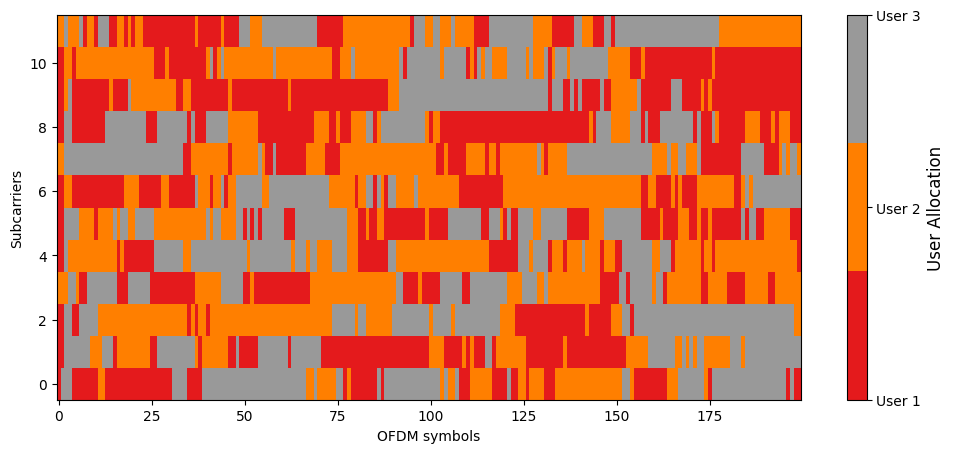

In [9]:
show_up_to_subcarrier = 100
show_up_to_symbol = 200

cmap = plt.get_cmap('Set1', num_ut)

plt.figure(figsize=(12, 5))
plt.imshow(ut_scheduled_hist[np.arange(min(show_up_to_symbol, num_slots*num_ofdm_symbols))[:, np.newaxis], 
                             np.arange(min(show_up_to_subcarrier, num_subcarriers))].T, cmap=cmap, aspect='auto')

# Add colorbar with custom ticks and labels
cbar = plt.colorbar(ticks=np.arange(num_ut))
cbar.ax.set_yticklabels([f'User {ut+1}' for ut in range(num_ut)])
cbar.set_label('User Allocation', fontsize=12)
plt.gca().invert_yaxis()
plt.xlabel('OFDM symbols')
plt.ylabel('Subcarriers')
plt.show()

Observe that each user receives roughly the same number of resources, which is
a known and desirable property of the PF scheduler.

In [10]:
for ut in range(num_ut):
    perc_ut = (ut_scheduled_hist==ut).sum() / (num_ofdm_symbols*num_subcarriers*num_slots)*100
    print(f'User {ut + 1} is scheduled on {perc_ut:.2f}% of available resources')

User 1 is scheduled on 34.38% of available resources
User 2 is scheduled on 35.21% of available resources
User 3 is scheduled on 30.42% of available resources


## Evaluate performance

It is interesting to compare the performance of the PF scheduler with that of a
random scheduler, which assigns resources to users uniformly at random.  
While
random scheduling also ensures a uniform distribution of resources, it lacks
opportunism and may allocate resources when channel conditions are unfavorable,
resulting in lower user throughput.


In [11]:
# Schedule users uniformly at random across the resource grid
ut_scheduled_rand_hist = config.tf_rng.uniform([num_slots*num_ofdm_symbols, num_subcarriers], minval=0, maxval=num_ut, dtype=tf.int32)
is_scheduled_rand_hist = tf.one_hot(ut_scheduled_rand_hist, num_ut, dtype=tf.float32)

rate_achieved_rand = np.sum(se_achievable_hist * is_scheduled_rand_hist.numpy(), axis=(-2,-3))

# Compute PF metric of random scheduling
pf_metric_rand = np.sum(np.log(rate_achieved_rand))

print('---------')
print('PF metric')
print('---------')
print(f'Random scheduling: {pf_metric_rand:.2f}')
print(f'PF scheduling: {pf_metric_pf:.2f}')

---------
PF metric
---------
Random scheduling: 26.55
PF scheduling: 27.65


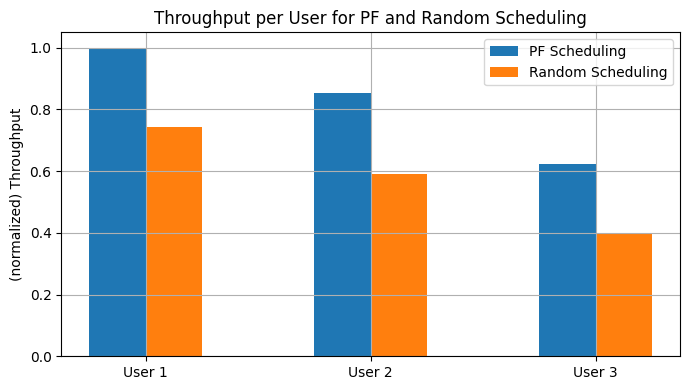

In [12]:
# Data for the histogram
users = ['User 1', 'User 2', 'User 3']

# Create the histogram
fig, ax = plt.subplots(figsize=(7, 4))
bar_width = 0.25
index = np.arange(len(users))

# Normalization factor
norm_fact = max(rate_achieved_pf)
# Throughput histogram
ax.bar(index, rate_achieved_pf / norm_fact, bar_width, label='PF Scheduling')
ax.bar(index + bar_width, rate_achieved_rand / norm_fact, bar_width, label='Random Scheduling')

ax.set_ylabel('(normalized) Throughput')
ax.set_title('Throughput per User for PF and Random Scheduling')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(users)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

## Conclusions

The [PFSchedulerSUMIMO](https://nvlabs.github.io/sionna/sys/api/scheduling.html#sionna.sys.PFSchedulerSUMIMO) class schedules users according the
proportional fairness (PF) criterion in a single-user MIMO scenario, where at
most one user can be scheduled in each resource.

By maximizing the sum of logarithms of user throughput, the PF scheduler
distributes resources uniformly across users while opportunistically scheduling
users when their channel conditions reach a local peak.

In this notebook, the achievable rate is modeled using a simple autoregressive
process and is assumed to be perfectly estimated.  
For more realistic settings, please refer to the more advanced 
[system-level simulation notebook](https://nvlabs.github.io/sionna/sys/tutorials/End-to-End_Example.html) and [Sionna SYS meets RT
notebook](https://nvlabs.github.io/sionna/sys/tutorials/SYS_Meets_RT.html).


## References

[1] A\. Jalali, R\. Padovani, R\. Pankaj, "Data throughput of CDMA-HDR a high efficiency-high data rate personal
    communication wireless system." VTC2000-Spring. 2000 IEEE 51st Vehicular
    Technology Conference Proceedings. Vol. 3. IEEE, 2000. 

[2] A\. L\. Stolyar, "Maximizing queueing network utility subject to
    stability: Greedy primal-dual algorithm". Queueing Systems, 50, pp. 401-457,
    2005. 

[3] M\. Andrews, L\. Qian, A\. Stolyar. "Optimal utility based
    multi-user throughput allocation subject to throughput constraints." Proceedings
    IEEE 24th Annual Joint Conference of the IEEE Computer and Communications
    Societies. Vol. 4. IEEE, 2005. 